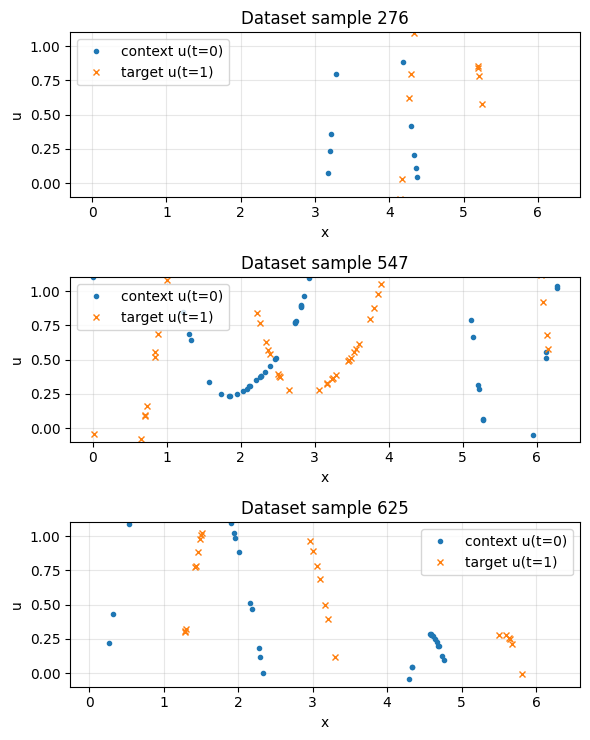

Epoch    1/50 — loss 3.510654
Epoch    5/50 — loss 2.969794
Epoch   10/50 — loss 2.727417
Epoch   15/50 — loss 1.590007
Epoch   20/50 — loss 0.779291
Epoch   25/50 — loss 0.453044
Epoch   30/50 — loss 0.324493
Epoch   35/50 — loss 0.293809
Epoch   40/50 — loss 0.224682
Epoch   45/50 — loss 0.192485
Epoch   50/50 — loss 0.181352


In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from typing import Optional

# ==========================================================
# 1.  Model definition (grid‑independent encoder–decoder)
# ==========================================================

class GridIndependentOperator(nn.Module):
    """Transformer‑based operator that maps scattered (x,u) context to values at new query points.
    Works for arbitrary spatial dimensionality (pos_dim) and channel count (val_dim)."""

    def __init__(self,
                 pos_dim: int = 1,
                 val_dim: int = 1,
                 out_dim: Optional[int] = None,
                 *,
                 d_pos: int = 32,
                 d_val: int = 64,
                 d_model: int = 128,
                 n_heads: int = 8,
                 enc_layers: int = 4,
                 dec_layers: int = 2,
                 mlp_hidden: int = 256):
        super().__init__()
        self.out_dim = val_dim if out_dim is None else out_dim

        # —— token embeddings ——
        self.pos_embed = nn.Sequential(
            nn.Linear(pos_dim, d_pos), nn.ReLU(), nn.Linear(d_pos, d_model)
        )
        self.val_embed = nn.Sequential(
            nn.Linear(val_dim, d_val), nn.ReLU(), nn.Linear(d_val, d_model)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # —— encoder & decoder ——
        enc_layer = nn.TransformerEncoderLayer(d_model, n_heads, mlp_hidden, batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=enc_layers)

        dec_layer = nn.TransformerDecoderLayer(d_model, n_heads, mlp_hidden, batch_first=True, activation="gelu")
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=dec_layers)

        # —— prediction head ——
        self.head = nn.Sequential(
            nn.Linear(d_model, mlp_hidden), nn.GELU(), nn.Linear(mlp_hidden, self.out_dim)
        )

    def forward(self, positions: torch.Tensor, values: torch.Tensor, query_pos: torch.Tensor) -> torch.Tensor:
        """parameters
        -----------
        positions : (B, N_ctx, pos_dim)
        values    : (B, N_ctx, val_dim)
        query_pos : (B, N_q,   pos_dim)
        returns    : (B, N_q,   out_dim)
        """
        B, N, _ = positions.shape
        M = query_pos.shape[1]

        ctx_tok = self.pos_embed(positions) + self.val_embed(values)  # (B,N,d)
        memory  = self.encoder(ctx_tok)                               # (B,N,d)

        q_tok   = self.cls_token.expand(B, M, -1) + self.pos_embed(query_pos)  # (B,M,d)
        dec_out = self.decoder(q_tok, memory)                        # (B,M,d)
        return self.head(dec_out)                                    # (B,M,out_dim)


# ==========================================================
# 2.  Dataset generator (random trig polynomial ≤ degree 3)
# ==========================================================

def trig_poly(x: torch.Tensor, coeffs: torch.Tensor):
    """Evaluate a real trigonometric polynomial up to degree‑3.
    coeffs shape: (..., 7) → [a0, a1, b1, a2, b2, a3, b3]
    x shape: (..., 1)
    Domain assumed x∈[0,1]; internally we use 2πk x as angle.
    """
    a0, a1, b1, a2, b2, a3, b3 = torch.unbind(coeffs, dim=-1)
    twopi = 2 * torch.pi
    angle = twopi * x  # (...,1)
    y = a0.unsqueeze(-1)
    y = y + a1.unsqueeze(-1) * torch.cos(1 * angle) + b1.unsqueeze(-1) * torch.sin(1 * angle)
    y = y + a2.unsqueeze(-1) * torch.cos(2 * angle) + b2.unsqueeze(-1) * torch.sin(2 * angle)
    y = y + a3.unsqueeze(-1) * torch.cos(3 * angle) + b3.unsqueeze(-1) * torch.sin(3 * angle)
    return y  # same shape as x


def build_trig_dataset(num_samples: int,
                       n_context: int,
                       n_query: int,
                       *,
                       coeff_scale: float = 1.0,
                       shift: float = 1.0,              # forward advection of +1 unit
                       domain: tuple = (0.0, 2*torch.pi),
                       device: str = "cpu") -> TensorDataset:
    """Generate dataset of random degree‑3 trig polynomials with a **+1 unit shift**.

    Inputs:
        context  : values f(x) at random x_ctx   (time t=0)
        queries  : random x_q                    (time t=1)
        targets  : f(x_q - shift) with periodic wrap on [0, 2π]
    """
    # random Fourier coefficients per sample (7 params)
    coeffs = torch.randn(num_samples, 7, device=device) * coeff_scale  # (S,7)

    L = domain[1] - domain[0]  # 2π by default

    # random context & query points in [0, 2π]
    x_ctx = torch.rand(num_samples, n_context, 1, device=device) * L + domain[0]
    x_q   = torch.rand(num_samples, n_query, 1, device=device) * L + domain[0]

    # evaluate polynomial at t=0 (context)
    u_ctx = trig_poly(x_ctx / L, coeffs.unsqueeze(1).expand(-1, n_context, -1))

    # shift queries back by +shift to get source positions under periodic BC
    x_src = (x_q - shift - domain[0]) % L + domain[0]
    u_q   = trig_poly(x_src / L, coeffs.unsqueeze(1).expand(-1, n_query, -1))

    return TensorDataset(x_ctx, u_ctx, x_q, u_q)


# ==========================================================
# 3.  Training & visualisation utilities
# ==========================================================.  Training & visualisation utilities
# ==========================================================

def train_from_dataset(model: GridIndependentOperator,
                       dataset: TensorDataset,
                       *,
                       epochs: int = 200,
                       batch_size: int = 64,
                       lr: float = 3e-4,
                       device: str = "cpu"):
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for ep in range(1, epochs + 1):
        running_loss = 0.0
        for x0, u0, qx, u1 in loader:
            x0, u0, qx, u1 = x0.to(device), u0.to(device), qx.to(device), u1.to(device)
            pred = model(x0, u0, qx)
            loss = mse(pred, u1)
            opt.zero_grad(); loss.backward(); opt.step()
            running_loss += loss.item() * x0.size(0)

        if ep % 5 == 0 or ep == 1:
            print(f"Epoch {ep:4d}/{epochs} — loss {running_loss / len(dataset):.6f}")


@torch.no_grad()
def visualize_dataset_samples(dataset: TensorDataset,
                              *,
                              count: int = 3,
                              device: str = "cpu"):
    """Plot random samples showing random context + query values."""
    idx = torch.randperm(len(dataset))[:count]
    samples = [dataset[i] for i in idx]

    fig, axes = plt.subplots(count, 1, figsize=(6, 2.5 * count))
    axes = axes if count > 1 else [axes]

    for i, (x0, u0, qx, u1) in enumerate(samples):
        # sort context & queries for visualization
        ctx_sorted, ctx_idx = torch.sort(x0.squeeze(-1))
        u0_sorted = u0.squeeze(-1)[ctx_idx]

        q_sorted, q_idx = torch.sort(qx.squeeze(-1))
        u1_sorted = u1.squeeze(-1)[q_idx]

        ax = axes[i]
        ax.plot(ctx_sorted, u0_sorted, "o", ms=3, label="context u(t=0)")
        ax.plot(q_sorted, u1_sorted, "x", ms=4, label="target u(t=1)")
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel("x"); ax.set_ylabel("u")
        ax.set_title(f"Dataset sample {idx[i].item()}")
        ax.grid(alpha=0.3); ax.legend()

    plt.tight_layout(); plt.show()


@torch.no_grad()
def visualize_predictions(model: GridIndependentOperator,
                          dataset: TensorDataset,
                          *,
                          count: int = 3,
                          device: str = "cpu"):
    """Overlay model predictions vs. ground‑truth for random samples."""
    model.eval().to(device)
    idx = torch.randperm(len(dataset))[:count]
    samples = [dataset[i] for i in idx]

    fig, axes = plt.subplots(count, 1, figsize=(6, 2.5 * count))
    axes = axes if count > 1 else [axes]

    for i, (x0, u0, qx, u1) in enumerate(samples):
        x0_t, u0_t, qx_t, u1_t = [t.unsqueeze(0).to(device) for t in (x0, u0, qx, u1)]
        pred = model(x0_t, u0_t, qx_t).cpu().squeeze(0)  # (N_q,1)

        # sort queries for plotting
        q_sorted, q_idx = torch.sort(qx.squeeze(-1))
        true_sorted = u1.squeeze(-1)[q_idx]
        pred_sorted = pred.squeeze(-1)[q_idx]

        ax = axes[i]
        # plot context
        ax.scatter(x0.squeeze(-1), u0.squeeze(-1), s=12, label="context u0", alpha=0.6)
        # plot true & predicted at queries
        ax.plot(q_sorted, true_sorted, "o", ms=4, label="true u1")
        ax.plot(q_sorted, pred_sorted, "--", label="pred")

        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel("x")
        ax.set_ylabel("u")
        ax.set_title(f"Prediction on sample {idx[i].item()}")
        ax.grid(alpha=0.3); ax.legend()

    plt.tight_layout(); plt.show()


dataset = build_trig_dataset(
    num_samples=1000,
    n_context=100,
    n_query=100
)

visualize_dataset_samples(dataset, count=3, device="cpu")

model = GridIndependentOperator(pos_dim=1, val_dim=1)

train_from_dataset(model, dataset, epochs=50, batch_size=128)


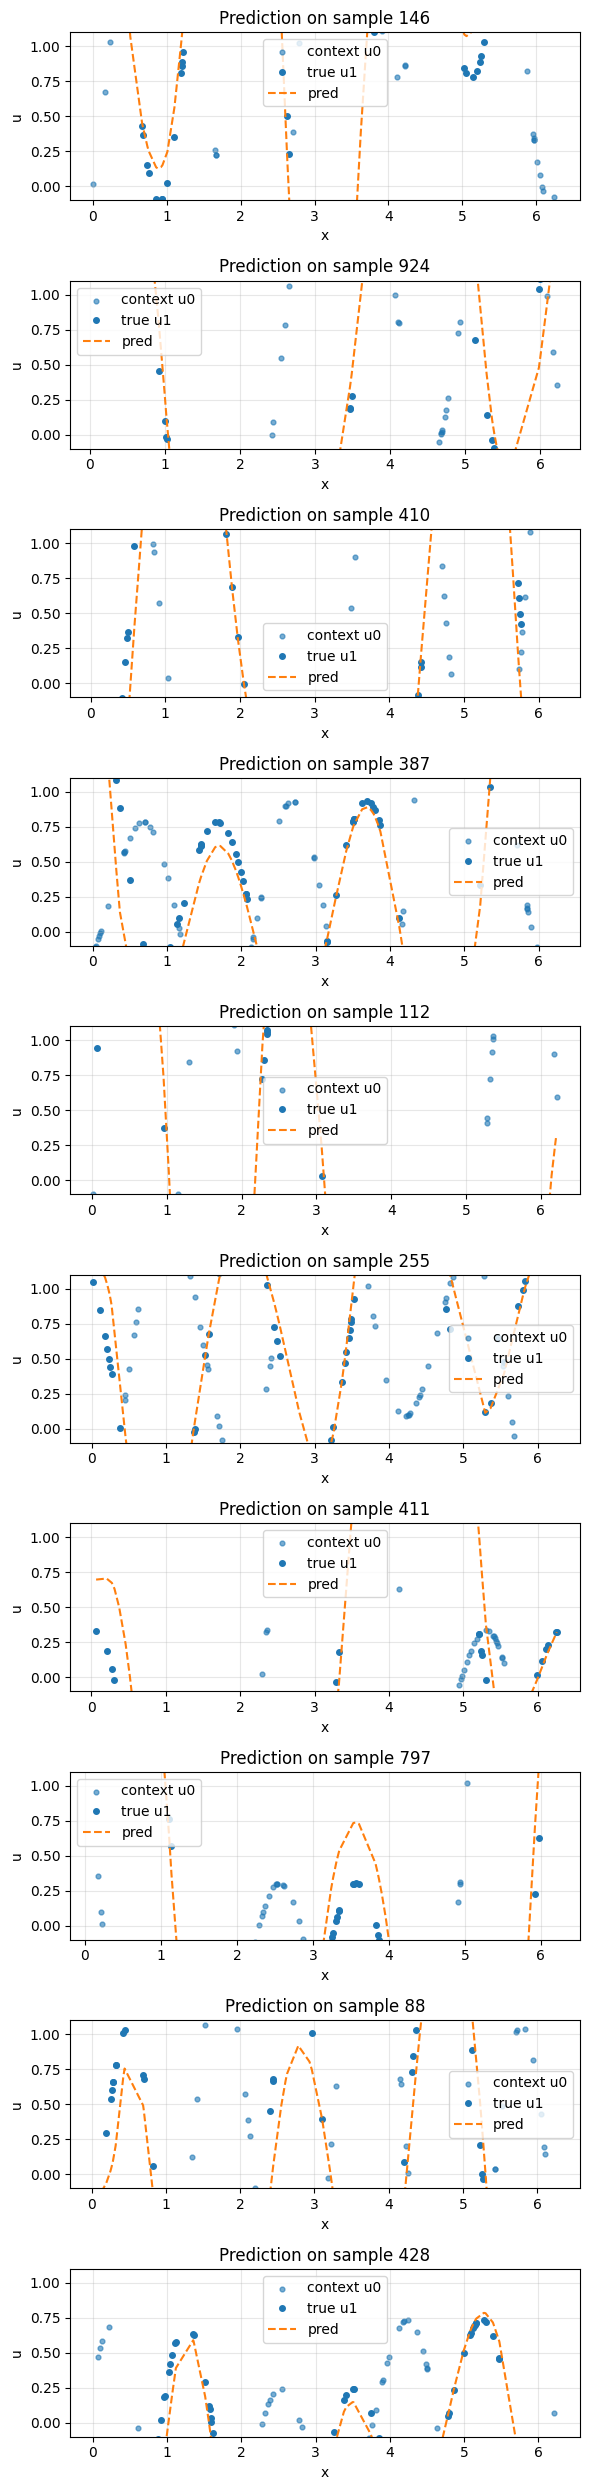

In [37]:
visualize_predictions(model, dataset, count=10)

In [38]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # grab a single batch of (inputs, targets)
    seqs, targets = next(iter(test_loader))        # seqs: (B, seq_len, m), targets: (B, m)
    # rebuild the full sequence: append target as the (seq_len+1)-th step
    full = torch.cat([seqs, targets.unsqueeze(1)], dim=1).cpu().numpy()  
    # full.shape == (B, seq_len+1, m)

# Plot evolution of two components for first 5 sequences
num_plot = 5
time = list(range(seq_len + 1))

plt.figure(figsize=(10, 6))
for i in range(num_plot):
    plt.subplot(num_plot, 1, i+1)
    plt.plot(time, full[i, :, 0], label='Component 0')
    plt.plot(time, full[i, :, 1], label='Component 1')
    plt.ylabel(f'Seq {i}')
    if i == 0:
        plt.legend(loc='upper left')

plt.xlabel('Time step')
plt.suptitle('Evolution of Two Components over Time')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


NameError: name 'test_loader' is not defined